### Historical Shape Indicator (HSI),  Visa Market

In [1]:
import pandas as pd
from pandas import DatetimeIndex
import datetime 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import scipy
from scipy import stats as scs
import statsmodels
from statsmodels import stats
from statsmodels.stats import weightstats
from statsmodels.stats.power import TTestIndPower
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sb
sb.set()
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
%matplotlib inline

#### Raw Data

In [2]:
def get_raw(sym='V'):
    '''
    download data and return data dictionary
    '''
    # download historical prices
    ts = TimeSeries(key='enter your access key')
    # Get json object with the intraday data and another with  the call's metadata
    data, meta_data = ts.get_daily_adjusted(sym, outputsize='full')
    return data

#### Format Raw Data

In [3]:
def format_raw(raw_dict):
    '''
    import raw dictionary
    format column names and sort date ascending
    return dataframe
    '''
    # reformat
    data = raw_dict.copy()
    df_raw = pd.DataFrame.from_dict(data).T
    df_raw.reset_index(level=0, inplace=True)
    df_raw = df_raw.rename(index=str, columns={'index':'date',
                                               '1. open': 'open', 
                                               '2. high': 'high',
                                               '3. low': 'low',
                                               '4. close':'close',
                                               '5. adjusted close':'adj_close',
                                               '6. volume':'volume',
                                               '7. dividend amount':'dividend',
                                               '8. split coefficient':'split',
                                              })
    df_raw = df_raw.sort_values(by='date', ascending=True)
    df_raw = df_raw.reset_index(drop=True)
    df_raw.date = pd.to_datetime(df_raw.date)
    
    return df_raw

In [4]:
def scale_adjusted(df_raw):
    '''
    import raw dataframe
    scale open,high,low, close to adjusted close
    return updated dataframe
    '''
    df = df_raw.copy()
    df_scale = pd.DataFrame()
    close = df.close.to_numpy().astype(float)
    adj = df.adj_close.to_numpy().astype(float)
    scale = adj / close
    df_scale['date'] = df['date'].copy()
    df_scale['open']=df.open.to_numpy().astype(float)*scale
    df_scale['high']=df.high.to_numpy().astype(float)*scale
    df_scale['low']=df.low.to_numpy().astype(float)*scale
    df_scale['close']=df.close.to_numpy().astype(float)*scale
    
    return df_scale

#### Preprocess Data

In [5]:
def compute_log_returns(prices):
    '''
    compute log returns
    '''
    return np.log(prices) - np.log(prices.shift(1))

In [6]:
def shift_returns(returns, shift_n):
    '''
    compute shift returns for trade assessment
    '''
    return returns.shift(shift_n)

In [7]:
def compute_proj(prices, lookahead_days):
    '''
    compute projected future lookahead returns
    lookahead_days is the number of days ahead we want to predict
    '''
    return (prices.shift(-lookahead_days) - prices)/prices

In [8]:
def compute_day_shape(prices, sigmas, dayspan):
    '''
    compute one day shape
    '''
    abs_deltas = (prices) - (prices.shift(dayspan))
    s_ratios = abs_deltas / sigmas
    ups = 3*(s_ratios>1)
    downs = 1*(s_ratios<-1)
    neuts = 2*((s_ratios>=-1)&(s_ratios<=1))      
    return (ups+downs+neuts)

In [9]:
def compute_shape(dayshape, dayspan):
    '''
    compute 5 day shape ordinals
    '''
    ago5s = 10000*(dayshape.shift(4*dayspan))
    ago4s = 1000*(dayshape.shift(3*dayspan))
    ago3s = 100*(dayshape.shift(2*dayspan))
    ago2s = 10*(dayshape.shift(1*dayspan))
    return (ago5s+ago4s+ago3s+ago2s+dayshape)

In [10]:
def preprocess(df):
    '''
    compute statistics 
    add return parameters
    add lookahead projections of 7 days
    use day shape spans of 1, 3 and 5 days
    build shape ordinals
    '''
    df_for = df.copy()
    
    # raw data overlaps
    shifts = [['o1','h1','l1','c1'],
              ['o2','h2','l2','c2'],
              ['o3','h3','l3','c3'],
              ['o4','h4','l4','c4'],
             ]
    # format df to calculate price estimates and standard deviations
    for j, shift in zip(range(1,6),shifts):
        df_for[shift[0]] = df_for.open.shift(-j)
        df_for[shift[1]] = df_for.high.shift(-j)
        df_for[shift[2]] = df_for.low.shift(-j)
        df_for[shift[3]] = df_for.close.shift(-j)

    # define price estimate columns for 1,3,5 day spans
    p1_col = df_for.loc[:,"open":"close"].astype(float)
    p3_col = df_for.loc[:,"open":"c2"].astype(float)
    p5_col = df_for.loc[:,"open":"c4"].astype(float)  
    p_cols = [p1_col, p3_col, p5_col]

    # compute price estimates and standard deviations for spans
    stats = [['pe1','sd1'],['pe3','sd3'],['pe5','sd5']]
    for stat, p_col in zip(stats, p_cols):
        df_for[stat[0]] = p_col.mean(axis=1)
        df_for[stat[1]] = p_col.std(axis=1)

    # keep date but leave raw data behind
    df_prep = df_for[['date','pe1','sd1','pe3','sd3','pe5','sd5']].copy()
    
    # add daily returns to df based on 1 day price estimates
    daily_returns = compute_log_returns(df_prep['pe1'])
    df_prep['log_ret'] = daily_returns
    
    # compute shift returns
    shift_1dlog = shift_returns(df_prep['log_ret'],-1)
    df_prep['shift_ret'] = shift_1dlog
    
    # add projections to df
    lookahead_days = 7
    aheads = compute_proj(df_prep['pe1'], lookahead_days)
    df_prep['proj'] = aheads
    
    # add day shapes to df
    dayshapes = ['ds1','ds3','ds5']
    dayspans = [1,3,5]
    for shape, stat, span in zip(dayshapes, stats, dayspans):
        df_prep[shape] = compute_day_shape(df_prep[stat[0]], df_prep[stat[1]], span)
        
    # add shapes to df
    shapes = ['shp1','shp3','shp5']
    for shape, dayshape, span in zip(shapes, dayshapes, dayspans):
        df_prep[shape] = compute_shape(df_prep[dayshape], span)

    #trim the head then format
    df_trim = df_prep[25:].copy()
    df_trim[['shp1','shp3','shp5']] = df_trim[['shp1','shp3','shp5']].astype(int)
    
    return df_trim  

In [11]:
def test_train_split(df_mkt, test_year):
    '''
    split preprocessed data into train and test dataframes
    train data comes from years prior to test year
    data in years beyond the test year is not used
    '''
    df = df_mkt.copy()
    years = df.date.map(lambda x: x.strftime('%Y')).astype(int)
    
    #train = years < test_year for 2 years behind
    train = ((test_year-3 < years) & (years < test_year))
    test = np.isin(years, test_year)

    df_train = df[train].copy()
    df_test = df[test].copy()
    
    return df_train, df_test

#### Shape Ranks

In [12]:
def compute_shaperank(df_train, shapename):
    '''
    enter preprocessed train data and shapename string
    return HSI dataframe for that shapename
    '''
    shapes = df_train[shapename]
    projs = df_train['proj']
    
    s_list = list(set(shapes))
    p_avgs = []
    p_stds = []
    for shape in s_list:
        p_avgs.append((projs*(shapes==shape)).mean())
        p_stds.append((projs*(shapes==shape)).std())
    
    # initiate dataframe build
    df_shape = pd.DataFrame()
    df_shape['shape'] = s_list
    df_shape['p_avg'] = p_avgs
    df_shape['p_std'] = p_stds
    
    # shape ratio as a mini sharpe
    df_shape['p_srs'] = df_shape['p_avg']/df_shape['p_std']
    df_shape = df_shape.sort_values(by=['p_srs'])
    df_shape = df_shape.reset_index(drop=True)
    
    # normalize shape ratios into indicator
    short_range = df_shape['p_srs'].max() - df_shape['p_srs'].min() 
    short_min = df_shape['p_srs'].min()
    df_shape['HSI'] = (df_shape['p_srs'] - short_min)/short_range
    
    return df_shape     

In [13]:
def build_hsi(df_train):
    '''
    import train dataframe
    return completed shape dataframe
    '''
    df1 = compute_shaperank(df_train, 'shp1')
    df3 = compute_shaperank(df_train, 'shp3')
    df5 = compute_shaperank(df_train, 'shp5')
    df_hsi = pd.concat({'shp1':df1, 'shp3':df3, 'shp5':df5}, axis=1)
    return df_hsi

In [14]:
def assign_hsi(df, df_shape):
    '''
    for daily market data
    lookup the HSI figures given shape ordinals
    return updated dataframe with daily HSC assignment
    '''
    df_mkt = df.copy()
    
    # HSI lookups
    shapenames = ['shp1','shp3','shp5']
    hsi_names = ['hsi1','hsi3','hsi5']
    
    for sname, hsi_name in zip(shapenames, hsi_names):
        lookups = []
        s_list = df_shape[sname]['shape'].tolist()
        for i,nrows in df_mkt.iterrows():
            shp = nrows[sname]
            # assign 0.5's for unknown shapes
            if shp in s_list:
                lookups.append(np.asscalar(df_shape[sname][df_shape[sname]['shape']==shp]['HSI'].values))
            else:
                lookups.append(0.5)
        df_mkt[hsi_name] = lookups
        
    # compile three into the average of the two closest
    nearest_two = []
    for i,nrows in df_mkt.iterrows():
        v1 = nrows['hsi1']
        v2 = nrows['hsi3']
        v3 = nrows['hsi5']
        diffs = np.abs([v1-v2, v2-v3, v1-v3])
        sums = [v1+v2, v2+v3, v1+v3]
        nearest_two.append(np.max((diffs==np.amin(diffs))*sums)/2)
        
    df_mkt['HSC'] = nearest_two

    return df_mkt

#### Trade Rules

In [15]:
def compute_trades(indicator, highT, lowT):
    '''
    compare HSC to thresholds
    return binaries of in/out days
    '''
    trades = []
    inout = 0
    for ind in indicator:
        # from out to enter
        if inout == 0:
            if ind > highT:
                trades.append(1)
                inout = 1
            else:
                trades.append(0)
        # from in to exit
        else:
            if ind < lowT:
                trades.append(0)
                inout = 0
            else:
                trades.append(1)
    return trades

In [16]:
def opt_tresh(seedLow, seedHigh, step_range, df):
    '''
    successive approximation applied to optimizing thresholds
    '''
    df_mkt = df.copy()
    bestL = 0
    bestH = 0
    bestR = 0
    for i in range(20):
        t_low = seedLow + step_range*i/20

        for j in range(20):
            t_high = seedHigh + step_range*j/20

            trade = compute_trades(df_mkt['HSC'], t_high, t_low)
            returns = df_mkt['shift_ret']*trade
            expret = (np.exp(returns[1:].T.sum())-1)*100

            if expret > bestR:
                bestL = t_low
                bestH = t_high
                bestR = expret
                
    return bestL, bestH

In [17]:
def thresholds(df_train):
    '''
    determine trade rule thresholds
    '''
    # trim leader NaN's
    df = df_train.iloc[:-7].copy()
    
    low = 0.25
    high = 0.75
    res = 0
    r_values = [0.5,0.25,0.125]
    for r in r_values:
        low, high = opt_tresh((low-(r/2)),(high-(r/2)),r,df)
    
    return low, high

In [18]:
def compute_trades(indicator, highT, lowT):
    '''
    compare HSC to thresholds
    return binaries of in/out days
    '''
    trades = []
    inout = 0
    for ind in indicator:
        # from out to enter
        if inout == 0:
            if ind > highT:
                trades.append(1)
                inout = 1
            else:
                trades.append(0)
        # from in to exit
        else:
            if ind < lowT:
                trades.append(0)
                inout = 0
            else:
                trades.append(1)
    return trades

#### Analysis Functions

In [19]:
def compute_trade_returns(df):
    '''
    compute trade returns
    '''
    return df['shift_ret']*df['trade']

In [20]:
def statistical_test(df):
    '''
    Unequal Variance Stats Test of equal Sample Size
    This is a two-sided test for the null hypothesis that:
    2 independent samples have identical average (expected) values.
    With a small p_value, the null hypothesis is rejected
    '''
    all_ins = df[df['trade']==1]['shift_ret'].dropna()
    all_outs = df[df['trade']==0]['shift_ret'].dropna()
    
    if len(all_ins)<len(all_outs):
        all_outs = np.asarray(np.random.choice(all_outs, len(all_ins)))
    else:
        all_ins = np.asarray(np.random.choice(all_ins, len(all_outs)))
    
    results = statsmodels.stats.weightstats.ttest_ind(all_ins, all_outs,
                                                      alternative="two-sided",
                                                      usevar="unequal")
    t_value = results[0]
    p_value = results[1]
    
    return t_value, p_value

In [21]:
def get_expected_return(returns):
    '''
    compute integrated return in percentage
    '''
    return (np.exp(returns[1:].T.sum())-1)*100

In [22]:
def get_volatility(returns):
    '''
    compute annualized volatility
    '''
    return np.std(returns)*np.sqrt(252)

In [23]:
def get_years(df_mkt):
    '''
    compute years for sharpe
    '''
    df = df_mkt.copy()
    df = df.reset_index(drop=True)
    return np.asscalar((df['date'].tail(1)-df['date'][0])/timedelta(days=365))

In [24]:
def get_sharpe(returns, years, vol_year):
    '''
    compute sharpe ratio assuming 3.5% risk free interest rate
    '''
    ret_year = (np.exp(returns[1:].T.sum())-1)/years
    risk_free = 0.035
    return (ret_year - risk_free) / vol_year

In [25]:
def get_benchmark(df_mkt, exp_return):
    '''
    compute beat the market percentage
    calculates S&P500 returns using same trade days
    converts log returns to simple percentage
    returns difference in percentage returns
    '''
    df_spy = pd.read_csv('spy_index_092419.csv')
    df_spy['date'] = pd.to_datetime(df_spy['date'])
    df_bench = pd.merge(df_spy[['date', 'shift_ret']], df_mkt[['date','trade']], on='date', how='inner')
    bench_returns = df_bench['shift_ret']*df_bench['trade']
    bench_return = (np.exp(bench_returns[1:].T.sum())-1)*100
    beat_percent = exp_return - bench_return
    return beat_percent

#### Processing Pipeline

In [26]:
def run_etl(ticker, equity):
    '''
    run ETL pipeline
    '''
    print('Runnning ETL for '+ ticker)
    dict_raw = get_raw(ticker)
    
    print('formatting')
    df_for = format_raw(dict_raw)
    df_scale = scale_adjusted(df_for)
    
    print('preprocessing')
    df_pre = preprocess(df_scale)
    df_pre['symbol'] = ticker
    
    print('begin test itterations')
    years = df_pre.date.map(lambda x: x.strftime('%Y')).astype(int).unique().tolist()
    df_res = pd.DataFrame() 
    
    for test_year in years[3:]:
        
        print('starting test year {}'.format(test_year))
        results = [ticker, equity, test_year]
        print('test-train split')
        df_train, df_test = test_train_split(df_pre[:-7], test_year)
        est_price = np.asscalar(df_test['pe1'].tail(1).values)
        results.append(est_price)

        print('training shapes')
        df_shape = build_hsi(df_train)
        df_train = assign_hsi(df_train, df_shape)
        df_test = assign_hsi(df_test, df_shape)

        print('optimizing trade thresholds')
        lowT, highT = thresholds(df_train)
        results.append(lowT)
        results.append(highT)
        
        print('computing trades')
        trades = compute_trades(df_test['HSC'], highT, lowT)
        df_test['trade'] = trades
        num_trades = ((np.diff(trades))==-1).sum() + trades[-1]
        results.append(num_trades)

        print('evaluating performance')
        returns = compute_trade_returns(df_test)
        results.append(np.count_nonzero(returns))

        tval, pval = statistical_test(df_test)
        results.append(tval)
        results.append(pval)
        print('t-value, p-value = ', tval, pval)

        exp_ret = get_expected_return(returns)
        results.append(exp_ret)
        print('expected return = ', exp_ret)

        vol = get_volatility(returns)
        results.append(vol)
        print('volatility = ', vol)

        years = get_years(df_test)
        results.append(years)
        print('years = ', years)

        sharpe = get_sharpe(returns, years, vol)
        results.append(sharpe)
        print('sharpe ratio = ', sharpe)

        beat_percent = get_benchmark(df_test, exp_ret)
        results.append(beat_percent)
        print('beat percent = ', beat_percent)

        print('saving result')
        df_res = df_res.append(pd.Series(results),ignore_index=True)
        
    print('formatting summary')
    cols = ['symbol','equity','test_year','price$','lowT','highT','#trades','in_days',
            't-val','p-val','exp_ret%','volatility','years','sharpe','beat%']
    df_res.columns = cols
    df_res.test_year = df_res.test_year.astype(int)
    df_res.in_days = df_res.in_days.astype(int)
       
    return df_res, df_test, df_shape

In [27]:
# Run ETL for one Market
ticker = 'V'
equity = 'Visa'
df_results, df_test, df_shape = run_etl(ticker, equity)
df_results.to_csv('visa_shape_102819.csv', index=None)
df_results.head()

Runnning ETL for V
formatting
preprocessing
begin test itterations
starting test year 2011
test-train split
training shapes
optimizing trade thresholds
computing trades
evaluating performance
t-value, p-value =  0.052610207824098136 0.9581645007101043
expected return =  35.0734894940846
volatility =  0.17259676013586037
years =  0.989041095890411
sharpe ratio =  1.8518375079171587
beat percent =  30.369756965569785
saving result
starting test year 2012
test-train split
training shapes
optimizing trade thresholds
computing trades
evaluating performance
t-value, p-value =  1.6227760950733254 0.10633896727920573
expected return =  33.594292595137
volatility =  0.11166518219236833
years =  0.9945205479452055
sharpe ratio =  2.711622774604826
beat percent =  25.669117805434038
saving result
starting test year 2013
test-train split
training shapes
optimizing trade thresholds
computing trades
evaluating performance
t-value, p-value =  2.4705776906610346 0.014450935345876468
expected return = 

,symbol,equity,test_year,price$,lowT,highT,#trades,in_days,t-val,p-val,exp_ret%,volatility,years,sharpe,beat%
0,V,Visa,2011,24.140825,0.13750,0.67500,14.0,200,0.052610,0.958165,35.073489,0.172597,0.989041,1.851838,30.369757
1,V,Visa,2012,35.651762,0.30000,0.75625,19.0,100,1.622776,0.106339,33.594293,0.111665,0.994521,2.711623,25.669118
2,V,Visa,2013,53.184720,0.21875,0.74375,14.0,163,2.470578,0.014451,52.054075,0.128628,0.994521,3.797073,28.582710
3,V,Visa,2014,63.794290,0.18125,0.68750,15.0,134,-0.023865,0.980980,9.034544,0.134732,0.994521,0.414477,4.014917
4,V,Visa,2015,75.876887,0.30625,0.76250,14.0,96,0.388587,0.698070,16.725242,0.150828,0.994521,0.882955,21.426308


In [28]:
# View results
df_results

,symbol,equity,test_year,price$,lowT,highT,#trades,in_days,t-val,p-val,exp_ret%,volatility,years,sharpe,beat%
0,V,Visa,2011,24.140825,0.13750,0.67500,14.0,200,0.052610,0.958165,35.073489,0.172597,0.989041,1.851838,30.369757
1,V,Visa,2012,35.651762,0.30000,0.75625,19.0,100,1.622776,0.106339,33.594293,0.111665,0.994521,2.711623,25.669118
2,V,Visa,2013,53.184720,0.21875,0.74375,14.0,163,2.470578,0.014451,52.054075,0.128628,0.994521,3.797073,28.582710
3,V,Visa,2014,63.794290,0.18125,0.68750,15.0,134,-0.023865,0.980980,9.034544,0.134732,0.994521,0.414477,4.014917
4,V,Visa,2015,75.876887,0.30625,0.76250,14.0,96,0.388587,0.698070,16.725242,0.150828,0.994521,0.882955,21.426308
5,V,Visa,2016,76.803595,0.29375,0.55000,33.0,169,1.916904,0.057164,17.284696,0.131720,0.989041,1.061052,8.448825
6,V,Visa,2017,113.127180,0.28750,0.76875,15.0,153,2.860153,0.004721,34.104995,0.086184,0.986301,3.606081,21.774856
7,V,Visa,2018,130.950964,0.29375,0.73125,13.0,188,-1.792506,0.075684,5.400655,0.173565,0.994521,0.111221,13.331135
8,V,Visa,2019,176.590000,0.25625,0.71250,15.0,127,-0.434630,0.664466,22.483021,0.121174,0.791781,2.054520,16.486876


#### Result Discussion  
>  The expected returns are all positive, amazing.  
>  The sharpe ratio > 1 in 2/3 of the cases, it's mostly good.  
>  The beat the market percentages are encouraging

#### Assess Results for 2019

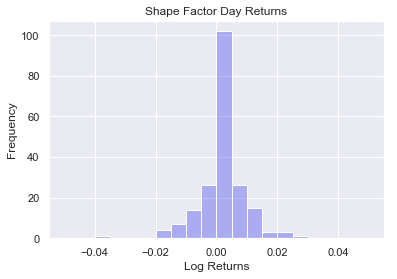

In [33]:
# returns histogram
returns = df_test['shift_ret']*df_test['trade']
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.title("Shape Factor Day Returns")
plt.hist(returns.dropna(),20,(-0.05,0.05), color = (.1,.1,.95,.3));

We want more positive days than negative and we're getting them.

In [30]:
# show day returns statistics
returns.describe()

count    202.000000
mean       0.001004
std        0.007652
min       -0.038905
25%       -0.000545
50%        0.000000
75%        0.003988
max        0.029844
dtype: float64

In [31]:
# t test definition
def analyze_alpha(expected_portfolio_returns_by_date, sigma):
    t_test =scs.ttest_1samp(expected_portfolio_returns_by_date,sigma)
    t_value = t_test[0]
    p_value = t_test[1]/2
    return t_value,p_value

In [32]:
# t test result
sigma = returns.std()
analyze_alpha(returns.dropna(), sigma)

(-12.347970687553484, 9.77361523121614e-27)

In this test, the null hypothesis is zero mean day returns.  
The trending market makes this impossible, so it may not mean much.

In [34]:
#expected returns over range
exp_ret = (np.exp(returns[1:].T.sum())-1)*100
exp_ret

22.483020599872617

We like to see trading profit here.

In [35]:
#annualized volatility
vol_year = np.std(returns)*np.sqrt(252)
vol_year

0.12117436284343147

Less than 20% seems risk worthy.

In [37]:
# compute years for sharpe
df_test = df_test.reset_index(drop=True)
years = np.asscalar((df_test['date'].tail(1)-df_test['date'][0])/timedelta(days=365))
years

0.7917808219178082

The year 2019 is not over yet.

In [38]:
# sharpe ratio on this trade strategy
ret_year = (np.exp(returns[1:].T.sum())-1)/years
risk_free = 0.035
sharpe = (ret_year - risk_free) / vol_year
sharpe

2.054519608109944

Greater than 1 is good, 2 is very good.

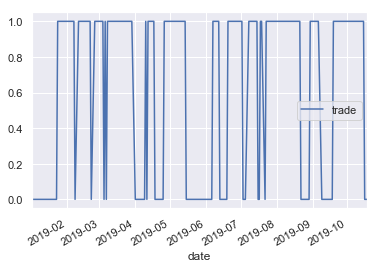

In [39]:
# show trades over last 3 months
df_test[-360:].plot(x='date',y='trade')

This reveals week to month trading more than daytrading.

#### Conclusion - indicator appears feasible.

In [55]:
df_test.to_csv('visa_index_102719.csv', index=None)

In [59]:
df_shape.to_csv('visa_hsi_lookup.csv', index=None)

### Disclaimer: this notebook is intended for educational purposes only and not recommended for real trading.